In [1]:
#---------------------------------code for bi classification--------------------------------------------------
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to the CSV file containing feature data and labels

csv_path = 'D:/thesis24/EEG_ANTENATAL_OPD/mat_eeg_final/bp_eeg/aftr_amp/experiment3/featuremap_stat_6_new.csv'


# Load data from CSV file
data = pd.read_csv(csv_path)

# Separate features (all columns except the last) and labels (last column)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Ensure that X and y have consistent lengths
if X.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]} samples, but y has {y.shape[0]} labels.")

def evaluate_model(X, y, classifiers, label_name):
    # Split data into training (70%) and remaining (30% for validation and testing)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Split remaining 30% equally into validation and test sets (15% each of total)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    results = []

    # Train classifiers and evaluate
    for clf_name, clf in classifiers:
        # Make a pipeline with standard scaler and classifier
        pipeline = make_pipeline(StandardScaler(), clf)
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # Predict on validation set
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Predict on test set
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1 score, precision, and recall on test set
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        
        # Store results
        results.append((clf_name, train_accuracy, val_accuracy, test_accuracy, f1, precision, recall))

    # Print results
    print(f"Results for {label_name}:")
    for result in results:
        print(f"{result[0]} - Train Acc: {result[1]:.2f}, Val Acc: {result[2]:.2f}, Test Acc: {result[3]:.2f}, F1: {result[4]:.2f}, Precision: {result[5]:.2f}, Recall: {result[6]:.2f}")

# List of classifiers
classifiers = [
    ("Tree Coarse", DecisionTreeClassifier(max_depth=5)),
    ("Tree Medium", DecisionTreeClassifier(max_depth=10)),
    ("Tree Fine", DecisionTreeClassifier(max_depth=None)),
    ("R Binary GLM Logistic", LogisticRegression(penalty='l2', solver='liblinear')),
    ("Efficient Logistic", LogisticRegression(penalty='l1', solver='liblinear')),
    ("SVM Linear", SVC(kernel='linear')),
    ("SVM Fine Gaussian", SVC(kernel='rbf', gamma=0.001)),
    ("SVM Cubic", SVC(kernel='poly', degree=3)),
    ("SVM Coarse Gaussian", SVC(kernel='rbf', gamma=1)),
    ("SVM Medium Gaussian", SVC(kernel='rbf', gamma=0.1)),
    ("SVM Quadratic", SVC(kernel='poly', degree=2)),
    ("D Linear", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ("D Quadratic", LinearDiscriminantAnalysis(solver='lsqr')),
    ("NB Gaussian", GaussianNB()),
    ("NB Kernel", GaussianNB()),  # GaussianNB does not have a kernel, keeping for the list
    ("KNN Fine", KNeighborsClassifier(n_neighbors=1)),
    ("KNN Cosine", KNeighborsClassifier(n_neighbors=5, metric='cosine')),
    ("KNN Coarse", KNeighborsClassifier(n_neighbors=10)),
    ("KNN Cubic", KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)),
    ("KNN Medium", KNeighborsClassifier(n_neighbors=5)),
    ("KNN Weighted", KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ("E Subspace Discriminant", BaggingClassifier(estimator=LinearDiscriminantAnalysis(), n_estimators=10)),
    ("Bagged Trees", BaggingClassifier(n_estimators=10)),
    ("RUSBoosted Trees", AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME')),
    ("Subspace KNN", BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=10)),
    ("Boosted Trees", AdaBoostClassifier(n_estimators=50)),
    ("ANN Narrow", MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)),
    ("ANN Medium", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ("ANN Wide", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ("ANN Bilayered", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)),
    ("ANN Trilayered", MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000)),
    ("K SVM", SVC(kernel='rbf')),
    ("Logistic Regression", LogisticRegression())
]

# Evaluate RS vs M (filter out AM data)
X_rs_m = X[(y == 0) | (y == 1)]
y_rs_m = y[(y == 0) | (y == 1)]
evaluate_model(X_rs_m, y_rs_m, classifiers, "RS vs M")

# Evaluate RS vs AM (filter out M data)
X_rs_am = X[(y == 0) | (y == 2)]
y_rs_am = y[(y == 0) | (y == 2)]
evaluate_model(X_rs_am, y_rs_am, classifiers, "RS vs AM")


Results for RS vs M:
Tree Coarse - Train Acc: 0.83, Val Acc: 0.82, Test Acc: 0.82, F1: 0.82, Precision: 0.85, Recall: 0.82
Tree Medium - Train Acc: 0.98, Val Acc: 0.94, Test Acc: 0.95, F1: 0.95, Precision: 0.95, Recall: 0.95
Tree Fine - Train Acc: 1.00, Val Acc: 0.94, Test Acc: 0.96, F1: 0.96, Precision: 0.96, Recall: 0.96
R Binary GLM Logistic - Train Acc: 0.64, Val Acc: 0.66, Test Acc: 0.66, F1: 0.66, Precision: 0.66, Recall: 0.66
Efficient Logistic - Train Acc: 0.64, Val Acc: 0.66, Test Acc: 0.66, F1: 0.66, Precision: 0.66, Recall: 0.66
SVM Linear - Train Acc: 0.65, Val Acc: 0.66, Test Acc: 0.66, F1: 0.66, Precision: 0.66, Recall: 0.66
SVM Fine Gaussian - Train Acc: 0.63, Val Acc: 0.65, Test Acc: 0.63, F1: 0.62, Precision: 0.63, Recall: 0.63
SVM Cubic - Train Acc: 0.84, Val Acc: 0.84, Test Acc: 0.82, F1: 0.82, Precision: 0.83, Recall: 0.82
SVM Coarse Gaussian - Train Acc: 1.00, Val Acc: 0.96, Test Acc: 0.97, F1: 0.97, Precision: 0.97, Recall: 0.97
SVM Medium Gaussian - Train Acc: 0.

In [2]:
#---------------------------------code for bi classification--------------------------------------------------
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to the CSV file containing feature data and labels

csv_path = 'D:/thesis24/EEG_ANTENATAL_OPD/mat_eeg_final/bp_eeg/aftr_amp/experiment3/feature_map_fifty.csv'


# Load data from CSV file
data = pd.read_csv(csv_path)

# Separate features (all columns except the last) and labels (last column)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Ensure that X and y have consistent lengths
if X.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]} samples, but y has {y.shape[0]} labels.")

def evaluate_model(X, y, classifiers, label_name):
    # Split data into training (70%) and remaining (30% for validation and testing)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Split remaining 30% equally into validation and test sets (15% each of total)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    results = []

    # Train classifiers and evaluate
    for clf_name, clf in classifiers:
        # Make a pipeline with standard scaler and classifier
        pipeline = make_pipeline(StandardScaler(), clf)
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # Predict on validation set
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Predict on test set
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1 score, precision, and recall on test set
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        
        # Store results
        results.append((clf_name, train_accuracy, val_accuracy, test_accuracy, f1, precision, recall))

    # Print results
    print(f"Results for {label_name}:")
    for result in results:
        print(f"{result[0]} - Train Acc: {result[1]:.2f}, Val Acc: {result[2]:.2f}, Test Acc: {result[3]:.2f}, F1: {result[4]:.2f}, Precision: {result[5]:.2f}, Recall: {result[6]:.2f}")

# List of classifiers
classifiers = [
    ("Tree Coarse", DecisionTreeClassifier(max_depth=5)),
    ("Tree Medium", DecisionTreeClassifier(max_depth=10)),
    ("Tree Fine", DecisionTreeClassifier(max_depth=None)),
    ("R Binary GLM Logistic", LogisticRegression(penalty='l2', solver='liblinear')),
    ("Efficient Logistic", LogisticRegression(penalty='l1', solver='liblinear')),
    ("SVM Linear", SVC(kernel='linear')),
    ("SVM Fine Gaussian", SVC(kernel='rbf', gamma=0.001)),
    ("SVM Cubic", SVC(kernel='poly', degree=3)),
    ("SVM Coarse Gaussian", SVC(kernel='rbf', gamma=1)),
    ("SVM Medium Gaussian", SVC(kernel='rbf', gamma=0.1)),
    ("SVM Quadratic", SVC(kernel='poly', degree=2)),
    ("D Linear", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ("D Quadratic", LinearDiscriminantAnalysis(solver='lsqr')),
    ("NB Gaussian", GaussianNB()),
    ("NB Kernel", GaussianNB()),  # GaussianNB does not have a kernel, keeping for the list
    ("KNN Fine", KNeighborsClassifier(n_neighbors=1)),
    ("KNN Cosine", KNeighborsClassifier(n_neighbors=5, metric='cosine')),
    ("KNN Coarse", KNeighborsClassifier(n_neighbors=10)),
    ("KNN Cubic", KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)),
    ("KNN Medium", KNeighborsClassifier(n_neighbors=5)),
    ("KNN Weighted", KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ("E Subspace Discriminant", BaggingClassifier(estimator=LinearDiscriminantAnalysis(), n_estimators=10)),
    ("Bagged Trees", BaggingClassifier(n_estimators=10)),
    ("RUSBoosted Trees", AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME')),
    ("Subspace KNN", BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=10)),
    ("Boosted Trees", AdaBoostClassifier(n_estimators=50)),
    ("ANN Narrow", MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)),
    ("ANN Medium", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ("ANN Wide", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ("ANN Bilayered", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)),
    ("ANN Trilayered", MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000)),
    ("K SVM", SVC(kernel='rbf')),
    ("Logistic Regression", LogisticRegression())
]

# Evaluate RS vs M (filter out AM data)
X_rs_m = X[(y == 0) | (y == 1)]
y_rs_m = y[(y == 0) | (y == 1)]
evaluate_model(X_rs_m, y_rs_m, classifiers, "RS vs M")

# Evaluate RS vs AM (filter out M data)
X_rs_am = X[(y == 0) | (y == 2)]
y_rs_am = y[(y == 0) | (y == 2)]
evaluate_model(X_rs_am, y_rs_am, classifiers, "RS vs AM")


C:\Users\IT\anaconda3\envs\GPUNEW\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results for RS vs M:
Tree Coarse - Train Acc: 0.88, Val Acc: 0.58, Test Acc: 0.77, F1: 0.75, Precision: 0.78, Recall: 0.77
Tree Medium - Train Acc: 1.00, Val Acc: 0.81, Test Acc: 0.73, F1: 0.70, Precision: 0.75, Recall: 0.73
Tree Fine - Train Acc: 1.00, Val Acc: 0.85, Test Acc: 0.69, F1: 0.65, Precision: 0.71, Recall: 0.69
R Binary GLM Logistic - Train Acc: 0.77, Val Acc: 0.62, Test Acc: 0.65, F1: 0.66, Precision: 0.68, Recall: 0.65
Efficient Logistic - Train Acc: 0.75, Val Acc: 0.62, Test Acc: 0.46, F1: 0.47, Precision: 0.48, Recall: 0.46
SVM Linear - Train Acc: 0.77, Val Acc: 0.65, Test Acc: 0.73, F1: 0.73, Precision: 0.76, Recall: 0.73
SVM Fine Gaussian - Train Acc: 0.53, Val Acc: 0.50, Test Acc: 0.38, F1: 0.21, Precision: 0.15, Recall: 0.38
SVM Cubic - Train Acc: 0.77, Val Acc: 0.65, Test Acc: 0.65, F1: 0.66, Precision: 0.71, Recall: 0.65
SVM Coarse Gaussian - Train Acc: 1.00, Val Acc: 0.92, Test Acc: 0.88, F1: 0.89, Precision: 0.91, Recall: 0.88
SVM Medium Gaussian - Train Acc: 0.

C:\Users\IT\anaconda3\envs\GPUNEW\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results for RS vs AM:
Tree Coarse - Train Acc: 0.83, Val Acc: 0.58, Test Acc: 0.62, F1: 0.61, Precision: 0.73, Recall: 0.62
Tree Medium - Train Acc: 1.00, Val Acc: 0.65, Test Acc: 0.85, F1: 0.85, Precision: 0.85, Recall: 0.85
Tree Fine - Train Acc: 1.00, Val Acc: 0.58, Test Acc: 0.88, F1: 0.89, Precision: 0.89, Recall: 0.88
R Binary GLM Logistic - Train Acc: 0.69, Val Acc: 0.58, Test Acc: 0.54, F1: 0.54, Precision: 0.58, Recall: 0.54
Efficient Logistic - Train Acc: 0.69, Val Acc: 0.62, Test Acc: 0.50, F1: 0.51, Precision: 0.53, Recall: 0.50
SVM Linear - Train Acc: 0.67, Val Acc: 0.58, Test Acc: 0.50, F1: 0.50, Precision: 0.55, Recall: 0.50
SVM Fine Gaussian - Train Acc: 0.53, Val Acc: 0.50, Test Acc: 0.38, F1: 0.21, Precision: 0.15, Recall: 0.38
SVM Cubic - Train Acc: 0.72, Val Acc: 0.50, Test Acc: 0.69, F1: 0.69, Precision: 0.77, Recall: 0.69
SVM Coarse Gaussian - Train Acc: 1.00, Val Acc: 0.81, Test Acc: 0.81, F1: 0.81, Precision: 0.87, Recall: 0.81
SVM Medium Gaussian - Train Acc: 0

In [5]:
#---------------------------------code for bi classification--------------------------------------------------
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to the CSV file containing feature data and labels

csv_path = 'D:/thesis24/EEG_ANTENATAL_OPD/mat_eeg_final/bp_eeg/aftr_amp/experiment3/feature_map_seven.csv'


# Load data from CSV file
data = pd.read_csv(csv_path)

# Separate features (all columns except the last) and labels (last column)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Ensure that X and y have consistent lengths
if X.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]} samples, but y has {y.shape[0]} labels.")

def evaluate_model(X, y, classifiers, label_name):
    # Split data into training (70%) and remaining (30% for validation and testing)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Split remaining 30% equally into validation and test sets (15% each of total)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    results = []

    # Train classifiers and evaluate
    for clf_name, clf in classifiers:
        # Make a pipeline with standard scaler and classifier
        pipeline = make_pipeline(StandardScaler(), clf)
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # Predict on validation set
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Predict on test set
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1 score, precision, and recall on test set
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        
        # Store results
        results.append((clf_name, train_accuracy, val_accuracy, test_accuracy, f1, precision, recall))

    # Print results
    print(f"Results for {label_name}:")
    for result in results:
        print(f"{result[0]} - Train Acc: {result[1]:.2f}, Val Acc: {result[2]:.2f}, Test Acc: {result[3]:.2f}, F1: {result[4]:.2f}, Precision: {result[5]:.2f}, Recall: {result[6]:.2f}")

# List of classifiers
classifiers = [
    ("Tree Coarse", DecisionTreeClassifier(max_depth=5)),
    ("Tree Medium", DecisionTreeClassifier(max_depth=10)),
    ("Tree Fine", DecisionTreeClassifier(max_depth=None)),
    ("R Binary GLM Logistic", LogisticRegression(penalty='l2', solver='liblinear')),
    ("Efficient Logistic", LogisticRegression(penalty='l1', solver='liblinear')),
    ("SVM Linear", SVC(kernel='linear')),
    ("SVM Fine Gaussian", SVC(kernel='rbf', gamma=0.001)),
    ("SVM Cubic", SVC(kernel='poly', degree=3)),
    ("SVM Coarse Gaussian", SVC(kernel='rbf', gamma=1)),
    ("SVM Medium Gaussian", SVC(kernel='rbf', gamma=0.1)),
    ("SVM Quadratic", SVC(kernel='poly', degree=2)),
    ("D Linear", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ("D Quadratic", LinearDiscriminantAnalysis(solver='lsqr')),
    ("NB Gaussian", GaussianNB()),
    ("NB Kernel", GaussianNB()),  # GaussianNB does not have a kernel, keeping for the list
    ("KNN Fine", KNeighborsClassifier(n_neighbors=1)),
    ("KNN Cosine", KNeighborsClassifier(n_neighbors=5, metric='cosine')),
    ("KNN Coarse", KNeighborsClassifier(n_neighbors=10)),
    ("KNN Cubic", KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)),
    ("KNN Medium", KNeighborsClassifier(n_neighbors=5)),
    ("KNN Weighted", KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ("E Subspace Discriminant", BaggingClassifier(estimator=LinearDiscriminantAnalysis(), n_estimators=10)),
    ("Bagged Trees", BaggingClassifier(n_estimators=10)),
    ("RUSBoosted Trees", AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME')),
    ("Subspace KNN", BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=10)),
    ("Boosted Trees", AdaBoostClassifier(n_estimators=50)),
    ("ANN Narrow", MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)),
    ("ANN Medium", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ("ANN Wide", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ("ANN Bilayered", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)),
    ("ANN Trilayered", MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000)),
    ("K SVM", SVC(kernel='rbf')),
    ("Logistic Regression", LogisticRegression())
]

# Evaluate RS vs M (filter out AM data)
X_rs_m = X[(y == 0) | (y == 1)]
y_rs_m = y[(y == 0) | (y == 1)]
evaluate_model(X_rs_m, y_rs_m, classifiers, "RS vs M")

# Evaluate RS vs AM (filter out M data)
X_rs_am = X[(y == 0) | (y == 2)]
y_rs_am = y[(y == 0) | (y == 2)]
evaluate_model(X_rs_am, y_rs_am, classifiers, "RS vs AM")


Results for RS vs M:
Tree Coarse - Train Acc: 0.65, Val Acc: 0.63, Test Acc: 0.62, F1: 0.61, Precision: 0.62, Recall: 0.62
Tree Medium - Train Acc: 0.87, Val Acc: 0.73, Test Acc: 0.78, F1: 0.78, Precision: 0.79, Recall: 0.78
Tree Fine - Train Acc: 1.00, Val Acc: 0.82, Test Acc: 0.83, F1: 0.83, Precision: 0.84, Recall: 0.83
R Binary GLM Logistic - Train Acc: 0.64, Val Acc: 0.64, Test Acc: 0.64, F1: 0.64, Precision: 0.64, Recall: 0.64
Efficient Logistic - Train Acc: 0.64, Val Acc: 0.65, Test Acc: 0.64, F1: 0.64, Precision: 0.65, Recall: 0.64
SVM Linear - Train Acc: 0.63, Val Acc: 0.64, Test Acc: 0.64, F1: 0.64, Precision: 0.64, Recall: 0.64
SVM Fine Gaussian - Train Acc: 0.61, Val Acc: 0.61, Test Acc: 0.64, F1: 0.64, Precision: 0.65, Recall: 0.64
SVM Cubic - Train Acc: 0.73, Val Acc: 0.75, Test Acc: 0.69, F1: 0.69, Precision: 0.70, Recall: 0.69
SVM Coarse Gaussian - Train Acc: 0.96, Val Acc: 0.89, Test Acc: 0.89, F1: 0.89, Precision: 0.89, Recall: 0.89
SVM Medium Gaussian - Train Acc: 0.

In [6]:
#---------------------------------code for bi classification--------------------------------------------------
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to the CSV file containing feature data and labels

csv_path = 'D:/thesis24/EEG_ANTENATAL_OPD/mat_eeg_final/bp_eeg/aftr_amp/experiment3/featuremap_24.csv'


# Load data from CSV file
data = pd.read_csv(csv_path)

# Separate features (all columns except the last) and labels (last column)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Ensure that X and y have consistent lengths
if X.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of samples: X has {X.shape[0]} samples, but y has {y.shape[0]} labels.")

def evaluate_model(X, y, classifiers, label_name):
    # Split data into training (70%) and remaining (30% for validation and testing)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Split remaining 30% equally into validation and test sets (15% each of total)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    results = []

    # Train classifiers and evaluate
    for clf_name, clf in classifiers:
        # Make a pipeline with standard scaler and classifier
        pipeline = make_pipeline(StandardScaler(), clf)
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # Predict on validation set
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Predict on test set
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1 score, precision, and recall on test set
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        
        # Store results
        results.append((clf_name, train_accuracy, val_accuracy, test_accuracy, f1, precision, recall))

    # Print results
    print(f"Results for {label_name}:")
    for result in results:
        print(f"{result[0]} - Train Acc: {result[1]:.2f}, Val Acc: {result[2]:.2f}, Test Acc: {result[3]:.2f}, F1: {result[4]:.2f}, Precision: {result[5]:.2f}, Recall: {result[6]:.2f}")

# List of classifiers
classifiers = [
    ("Tree Coarse", DecisionTreeClassifier(max_depth=5)),
    ("Tree Medium", DecisionTreeClassifier(max_depth=10)),
    ("Tree Fine", DecisionTreeClassifier(max_depth=None)),
    ("R Binary GLM Logistic", LogisticRegression(penalty='l2', solver='liblinear')),
    ("Efficient Logistic", LogisticRegression(penalty='l1', solver='liblinear')),
    ("SVM Linear", SVC(kernel='linear')),
    ("SVM Fine Gaussian", SVC(kernel='rbf', gamma=0.001)),
    ("SVM Cubic", SVC(kernel='poly', degree=3)),
    ("SVM Coarse Gaussian", SVC(kernel='rbf', gamma=1)),
    ("SVM Medium Gaussian", SVC(kernel='rbf', gamma=0.1)),
    ("SVM Quadratic", SVC(kernel='poly', degree=2)),
    ("D Linear", LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')),
    ("D Quadratic", LinearDiscriminantAnalysis(solver='lsqr')),
    ("NB Gaussian", GaussianNB()),
    ("NB Kernel", GaussianNB()),  # GaussianNB does not have a kernel, keeping for the list
    ("KNN Fine", KNeighborsClassifier(n_neighbors=1)),
    ("KNN Cosine", KNeighborsClassifier(n_neighbors=5, metric='cosine')),
    ("KNN Coarse", KNeighborsClassifier(n_neighbors=10)),
    ("KNN Cubic", KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)),
    ("KNN Medium", KNeighborsClassifier(n_neighbors=5)),
    ("KNN Weighted", KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ("E Subspace Discriminant", BaggingClassifier(estimator=LinearDiscriminantAnalysis(), n_estimators=10)),
    ("Bagged Trees", BaggingClassifier(n_estimators=10)),
    ("RUSBoosted Trees", AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, algorithm='SAMME')),
    ("Subspace KNN", BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=10)),
    ("Boosted Trees", AdaBoostClassifier(n_estimators=50)),
    ("ANN Narrow", MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)),
    ("ANN Medium", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ("ANN Wide", MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)),
    ("ANN Bilayered", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)),
    ("ANN Trilayered", MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000)),
    ("K SVM", SVC(kernel='rbf')),
    ("Logistic Regression", LogisticRegression())
]

# Evaluate RS vs M (filter out AM data)
X_rs_m = X[(y == 0) | (y == 1)]
y_rs_m = y[(y == 0) | (y == 1)]
evaluate_model(X_rs_m, y_rs_m, classifiers, "RS vs M")

# Evaluate RS vs AM (filter out M data)
X_rs_am = X[(y == 0) | (y == 2)]
y_rs_am = y[(y == 0) | (y == 2)]
evaluate_model(X_rs_am, y_rs_am, classifiers, "RS vs AM")


Results for RS vs M:
Tree Coarse - Train Acc: 0.88, Val Acc: 0.86, Test Acc: 0.87, F1: 0.87, Precision: 0.87, Recall: 0.87
Tree Medium - Train Acc: 0.96, Val Acc: 0.93, Test Acc: 0.95, F1: 0.95, Precision: 0.95, Recall: 0.95
Tree Fine - Train Acc: 1.00, Val Acc: 0.96, Test Acc: 0.97, F1: 0.97, Precision: 0.97, Recall: 0.97
R Binary GLM Logistic - Train Acc: 0.69, Val Acc: 0.70, Test Acc: 0.69, F1: 0.69, Precision: 0.69, Recall: 0.69
Efficient Logistic - Train Acc: 0.69, Val Acc: 0.70, Test Acc: 0.69, F1: 0.69, Precision: 0.69, Recall: 0.69
SVM Linear - Train Acc: 0.70, Val Acc: 0.72, Test Acc: 0.71, F1: 0.71, Precision: 0.71, Recall: 0.71
SVM Fine Gaussian - Train Acc: 0.68, Val Acc: 0.69, Test Acc: 0.68, F1: 0.68, Precision: 0.68, Recall: 0.68
SVM Cubic - Train Acc: 0.78, Val Acc: 0.78, Test Acc: 0.76, F1: 0.76, Precision: 0.77, Recall: 0.76
SVM Coarse Gaussian - Train Acc: 0.95, Val Acc: 0.92, Test Acc: 0.93, F1: 0.93, Precision: 0.93, Recall: 0.93
SVM Medium Gaussian - Train Acc: 0.

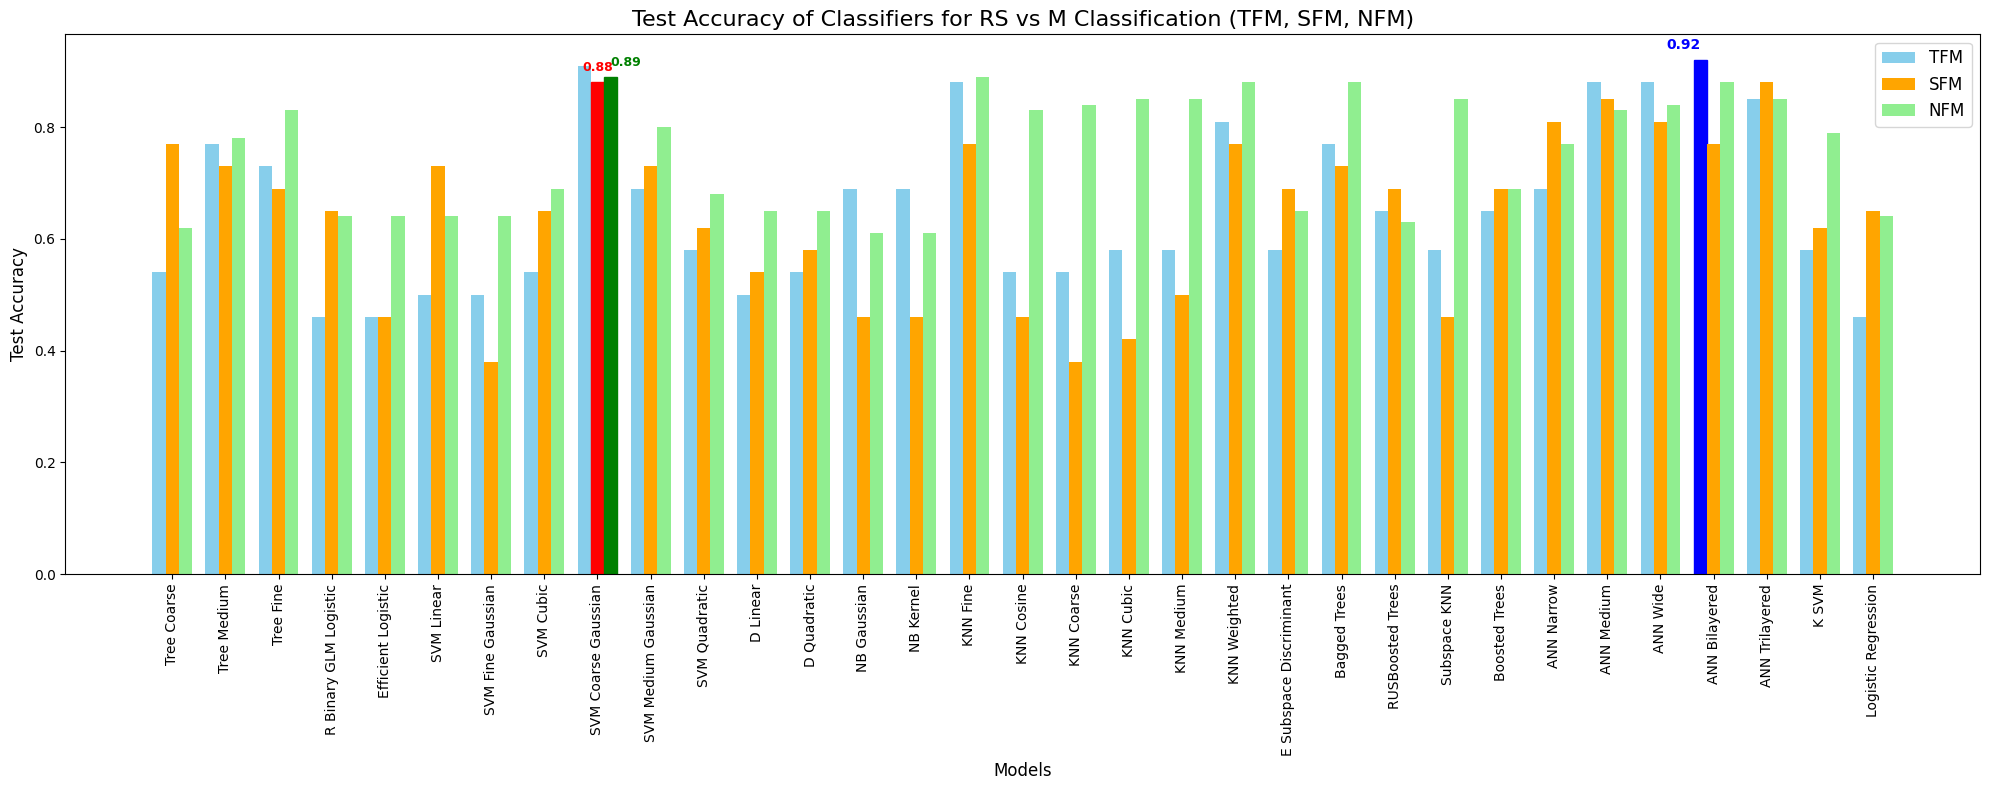

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Models (common for all feature maps)
models = [
    "Tree Coarse", "Tree Medium", "Tree Fine", "R Binary GLM Logistic", 
    "Efficient Logistic", "SVM Linear", "SVM Fine Gaussian", "SVM Cubic", 
    "SVM Coarse Gaussian", "SVM Medium Gaussian", "SVM Quadratic", "D Linear", 
    "D Quadratic", "NB Gaussian", "NB Kernel", "KNN Fine", "KNN Cosine", 
    "KNN Coarse", "KNN Cubic", "KNN Medium", "KNN Weighted", 
    "E Subspace Discriminant", "Bagged Trees", "RUSBoosted Trees", 
    "Subspace KNN", "Boosted Trees", "ANN Narrow", "ANN Medium", 
    "ANN Wide", "ANN Bilayered", "ANN Trilayered", "K SVM", 
    "Logistic Regression"
]

# Test Accuracy Data for TFM, SFM, and NFM
test_acc_tfm = [
    0.54, 0.77, 0.73, 0.46, 0.46, 0.50, 0.50, 0.54, 0.91, 0.69, 0.58, 0.50, 
    0.54, 0.69, 0.69, 0.88, 0.54, 0.54, 0.58, 0.58, 0.81, 0.58, 0.77, 0.65, 
    0.58, 0.65, 0.69, 0.88, 0.88, 0.92, 0.85, 0.58, 0.46
]

test_acc_sfm = [
    0.77, 0.73, 0.69, 0.65, 0.46, 0.73, 0.38, 0.65, 0.88, 0.73, 0.62, 0.54, 
    0.58, 0.46, 0.46, 0.77, 0.46, 0.38, 0.42, 0.50, 0.77, 0.69, 0.73, 0.69, 
    0.46, 0.69, 0.81, 0.85, 0.81, 0.77, 0.88, 0.62, 0.65
]

test_acc_nfm = [
    0.62, 0.78, 0.83, 0.64, 0.64, 0.64, 0.64, 0.69, 0.89, 0.80, 0.68, 0.65, 
    0.65, 0.61, 0.61, 0.89, 0.83, 0.84, 0.85, 0.85, 0.88, 0.65, 0.88, 0.63, 
    0.85, 0.69, 0.77, 0.83, 0.84, 0.88, 0.85, 0.79, 0.64
]

# Set width for bars and calculate indices
bar_width = 0.25
index = np.arange(len(models))

# Identify indices of the highest accuracy for each feature map
max_idx_tfm = np.argmax(test_acc_tfm)
max_idx_sfm = np.argmax(test_acc_sfm)
max_idx_nfm = np.argmax(test_acc_nfm)

# Plotting
plt.figure(figsize=(20, 8))
bars_tfm = plt.bar(index, test_acc_tfm, bar_width, label='TFM', color='skyblue')
bars_sfm = plt.bar(index + bar_width, test_acc_sfm, bar_width, label='SFM', color='orange')
bars_nfm = plt.bar(index + 2 * bar_width, test_acc_nfm, bar_width, label='NFM', color='lightgreen')

# Highlight the highest bars
bars_tfm[max_idx_tfm].set_color('blue')
bars_sfm[max_idx_sfm].set_color('red')
bars_nfm[max_idx_nfm].set_color('green')

# Add annotations for highest values
plt.text(max_idx_tfm, test_acc_tfm[max_idx_tfm] + 0.02, f'{test_acc_tfm[max_idx_tfm]:.2f}', 
         ha='right', fontsize=10, color='blue', fontweight='bold')
plt.text(max_idx_sfm + bar_width, test_acc_sfm[max_idx_sfm] + 0.02, f'{test_acc_sfm[max_idx_sfm]:.2f}', 
         ha='center', fontsize=9, color='red', fontweight='bold')
plt.text(max_idx_nfm + 2 * bar_width, test_acc_nfm[max_idx_nfm] + 0.02, f'{test_acc_nfm[max_idx_nfm]:.2f}', 
         ha='left', fontsize=9, color='green', fontweight='bold')

# Adding labels and titles
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy of Classifiers for RS vs M Classification (TFM, SFM, NFM)', fontsize=16)
plt.xticks(index + bar_width, models, rotation=90, fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure in HD quality
output_path = r"D:\thesis24\EEG_ANTENATAL_OPD\mat_eeg_final\bp_eeg\aftr_amp\experiment7\test_accuracy_plot_hd_highlighted.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


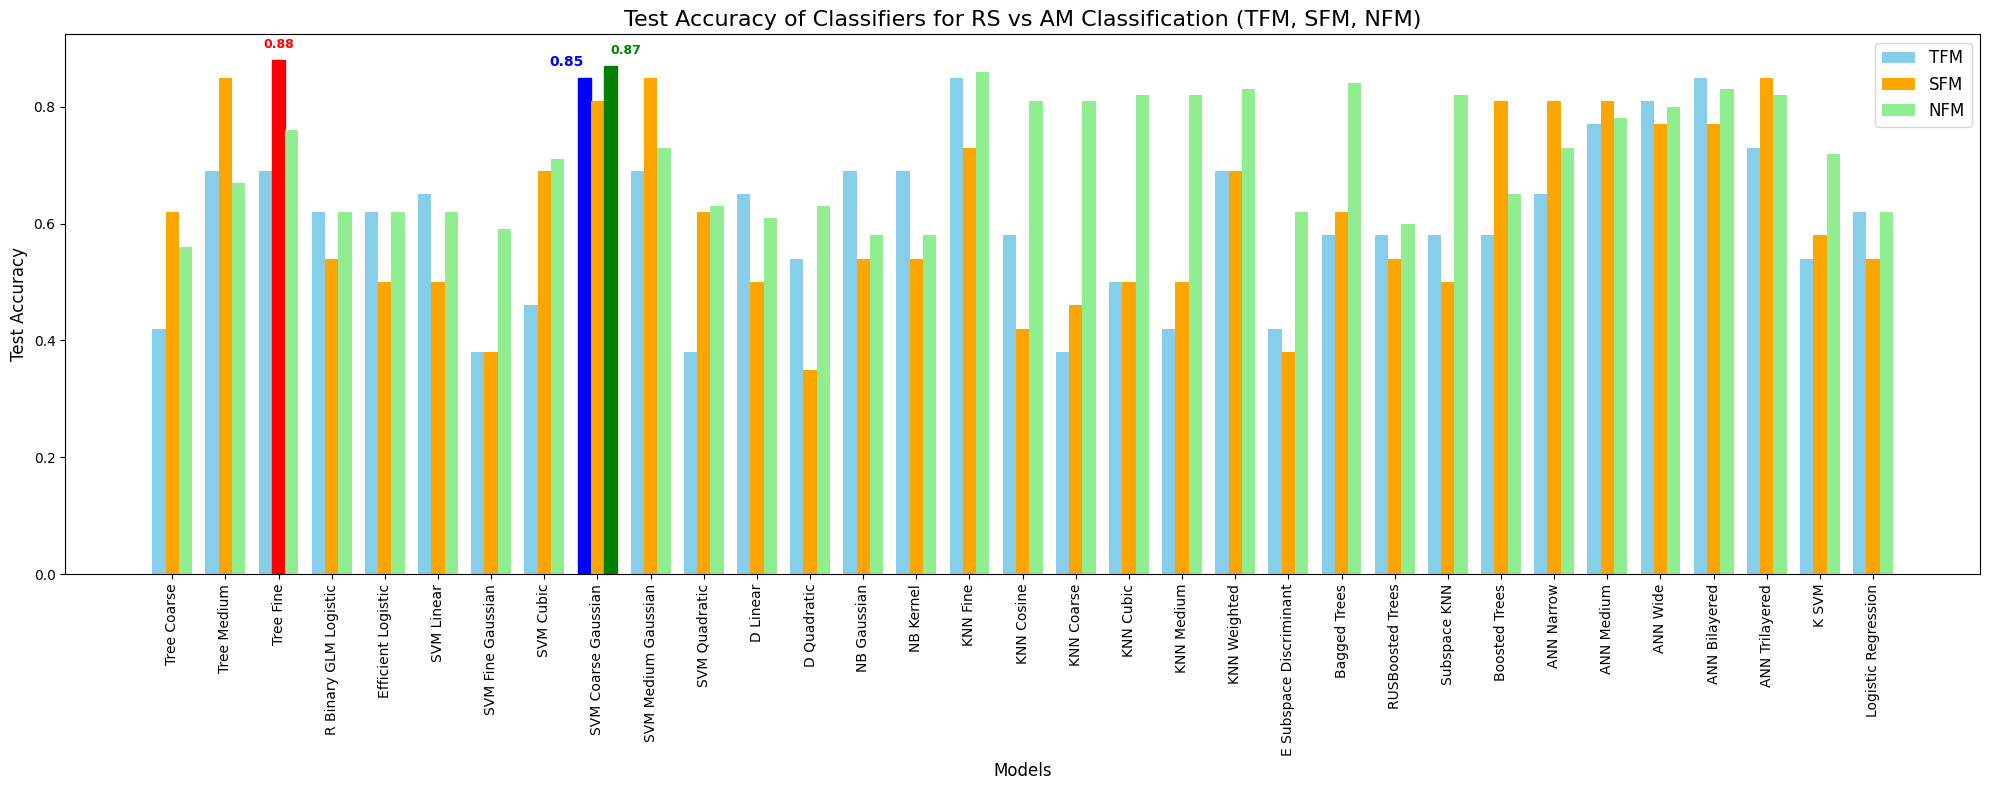

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Models (common for all feature maps)
models = [
    "Tree Coarse", "Tree Medium", "Tree Fine", "R Binary GLM Logistic", 
    "Efficient Logistic", "SVM Linear", "SVM Fine Gaussian", "SVM Cubic", 
    "SVM Coarse Gaussian", "SVM Medium Gaussian", "SVM Quadratic", "D Linear", 
    "D Quadratic", "NB Gaussian", "NB Kernel", "KNN Fine", "KNN Cosine", 
    "KNN Coarse", "KNN Cubic", "KNN Medium", "KNN Weighted", 
    "E Subspace Discriminant", "Bagged Trees", "RUSBoosted Trees", 
    "Subspace KNN", "Boosted Trees", "ANN Narrow", "ANN Medium", 
    "ANN Wide", "ANN Bilayered", "ANN Trilayered", "K SVM", 
    "Logistic Regression"
]

# Test Accuracy Data for TFM, SFM, and NFM
test_acc_tfm = [
    0.42, 0.69, 0.69, 0.62, 0.62, 0.65, 0.38, 0.46, 0.85, 0.69, 0.38, 0.65, 
    0.54, 0.69, 0.69, 0.85, 0.58, 0.38, 0.50, 0.42, 0.69, 0.42, 0.58, 0.58, 
    0.58, 0.58, 0.65, 0.77, 0.81, 0.85, 0.73, 0.54, 0.62
]

test_acc_sfm = [
    0.62, 0.85, 0.88, 0.54, 0.50, 0.50, 0.38, 0.69, 0.81, 0.85, 0.62, 0.50, 
    0.35, 0.54, 0.54, 0.73, 0.42, 0.46, 0.50, 0.50, 0.69, 0.38, 0.62, 0.54,
    0.50, 0.81, 0.81, 0.81, 0.77, 0.77, 0.85, 0.58, 0.54
]

test_acc_nfm = [
    0.56, 0.67, 0.76, 0.62, 0.62, 0.62, 0.59, 0.71, 0.87, 0.73, 0.63, 0.61, 
    0.63, 0.58, 0.58, 0.86, 0.81, 0.81, 0.82, 0.82, 0.83, 0.62, 0.84, 0.60, 
    0.82, 0.65, 0.73, 0.78, 0.80, 0.83, 0.82, 0.72, 0.62
]

# Set width for bars and calculate indices
bar_width = 0.25
index = np.arange(len(models))

# Identify indices of the highest accuracy for each feature map
max_idx_tfm = np.argmax(test_acc_tfm)
max_idx_sfm = np.argmax(test_acc_sfm)
max_idx_nfm = np.argmax(test_acc_nfm)

# Plotting
plt.figure(figsize=(20, 8))
bars_tfm = plt.bar(index, test_acc_tfm, bar_width, label='TFM', color='skyblue')
bars_sfm = plt.bar(index + bar_width, test_acc_sfm, bar_width, label='SFM', color='orange')
bars_nfm = plt.bar(index + 2 * bar_width, test_acc_nfm, bar_width, label='NFM', color='lightgreen')

# Highlight the highest bars
bars_tfm[max_idx_tfm].set_color('blue')
bars_sfm[max_idx_sfm].set_color('red')
bars_nfm[max_idx_nfm].set_color('green')

# Add annotations for highest values
plt.text(max_idx_tfm, test_acc_tfm[max_idx_tfm] + 0.02, f'{test_acc_tfm[max_idx_tfm]:.2f}', 
         ha='right', fontsize=10, color='blue', fontweight='bold')
plt.text(max_idx_sfm + bar_width, test_acc_sfm[max_idx_sfm] + 0.02, f'{test_acc_sfm[max_idx_sfm]:.2f}', 
         ha='center', fontsize=9, color='red', fontweight='bold')
plt.text(max_idx_nfm + 2 * bar_width, test_acc_nfm[max_idx_nfm] + 0.02, f'{test_acc_nfm[max_idx_nfm]:.2f}', 
         ha='left', fontsize=9, color='green', fontweight='bold')

# Adding labels and titles
plt.xlabel('Models', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Test Accuracy of Classifiers for RS vs AM Classification (TFM, SFM, NFM)', fontsize=16)
plt.xticks(index + bar_width, models, rotation=90, fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure in HD quality
output_path = r"D:\thesis24\EEG_ANTENATAL_OPD\mat_eeg_final\bp_eeg\aftr_amp\experiment7\test_accuracy_plot_hd_highlighted_RSvsAM.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
